# Równania różniczkowe cząstkowe na GPU


Cząstkowe równania róźniczkowe są chyba najbardziej popularnym przedmiotem obliczeń naukowych (licząc popularność czasem procesora). Ich implementacja na architekrurach równoległych jest nieco mniej trywialna niż np. równania stochatycznego. 

Poniższy materiał prezentuje prosty schemat całkowania równań typu parabolicznego. Wykorzystana zostanie siatka regularna i metoda róźnic skończonych. Pomimo tego schemat podany w tym materiale może po nieznacznych rozszerzeniu posłużyć do rozwiązywania szeregu problemów z fizyki.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
import pycuda.gpuarray as gpuarray

import numpy as np
from pycuda.compiler import SourceModule
import pycuda.driver as cuda

try:
    ctx.pop()
    ctx.detach()
except:
    print "No CTX!"

cuda.init()
device = cuda.Device(0)
ctx = device.make_context()
print device.name(), device.compute_capability(),device.total_memory()/1024.**3,"GB"


No CTX!
GeForce GTX TITAN Black (3, 5) 5.99981689453 GB


## The Laplace operator in 1d, example


Zobaczmy jak można zaimplementowac operator Laplace'a na CUDA:


In [3]:
u = np.array([1,1,1,2,1,1,1],dtype=np.float32)
u_g = gpuarray.to_gpu(u)
du_g = gpuarray.empty_like(u_g)

In [4]:
print u

[ 1.  1.  1.  2.  1.  1.  1.]


In [5]:
from pycuda.compiler import SourceModule

nx = 7
ny = 7 
mod = SourceModule("""
    __global__ void laplace1d(float *a,float *da)
    {
      int idx = threadIdx.x + threadIdx.y*4;

      float fe,fw;
      int nx=%d;
      //int ny=%d;
      int i = idx;
      
      if(i>0) {
           fw = a[i-1]; 
        }
      else{
          fw = a[nx-1];
      }

      if(i<(nx-1)) {
           fe = a[i+1]; 
        }
      else{
          fe = a[0];
      }

     da[idx] = fw+fe - 2.0f*a[idx];

    }
    """ % (nx,ny) )


In [6]:
func = mod.get_function("laplace1d")

In [7]:
func(u_g,du_g, block=(4,4,1), grid=(1,1))

In [8]:
du_g.get()

array([ 0.,  0.,  1., -2.,  1.,  0.,  0.], dtype=float32)

Wynik jest zgodny z oczekiwaniem, mając zadany wektor wejściowy można było się tego spodziewać.
(patrz np. https://sage2.icse.us.edu.pl/home/pub/225/)

## The 1d reaction diffusion equation

Zaimplementujemy teraz równanie Fisher Kologomorowa w jednym wymiarze:

In [9]:
import pycuda.gpuarray as gpuarray
import pycuda.autoinit
from pycuda.compiler import SourceModule
from string import Template

blocks = 64
block_size = 64
nx = blocks*block_size
print "Nx = ",nx
l = 100
#dt = 0.00008


Dyf = 1.0
dt = 0.2/(Dyf*(nx-1)**2/l**2) # 0.2 z warunku CFL, krok nie moze byc mniejszy
print "dt=",dt
pars = {'nx':nx,'C':Dyf*(nx-1)**2/l**2,'r':1.0,'dt':dt}

src = """
    __device__ float laplace1d(float *a)
    {{
      int idx = blockDim.x*blockIdx.x + threadIdx.x;

      float fe,fw;
      int nx={nx};
      
      int i = idx;
      
      if(i>0) {{
           fw = a[i-1]; 
        }}
      else{{
          fw = a[nx-1];
      }}

      if(i<(nx-1)) {{
           fe = a[i+1]; 
        }}
      else{{
          fe = a[0];
      }}

     return(  fw+fe - 2.0f * a[idx] );

    }}


    __global__ void iterate_RDS(float *a,float *da)
    {{
      int idx = blockDim.x*blockIdx.x + threadIdx.x;
      float u;
       
      u = a[idx]; 
           
      da[idx] = u + {dt}*( {r}*u*(1-u) + {C}*laplace1d(a) );
    }}
    """.format(**pars)

mod = SourceModule(src)
RDS = mod.get_function("iterate_RDS")

Nx =  4096
dt= 0.000119267518535


In [10]:
u = np.zeros(nx,dtype=np.float32)
u[int(nx/2)-20:int(nx/2)+20]=1.0

u_g = gpuarray.to_gpu(u)
du_g = gpuarray.empty_like(u_g)


Calling this many times will plot solution and IC:

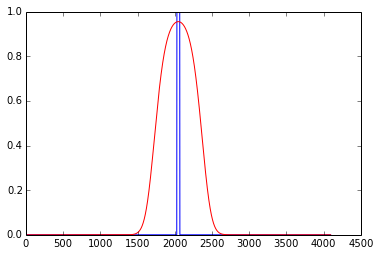

In [12]:
for i in range(12111):
    RDS(u_g,du_g, block=(block_size,1,1), grid=(blocks,1))
    RDS(du_g,u_g, block=(block_size,1,1), grid=(blocks,1))

plt.plot(u)
plt.plot(u_g.get(),color='red')


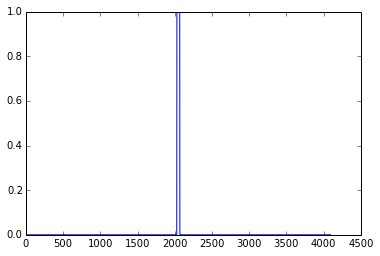

In [13]:
from IPython.core.display import clear_output,display

f, ax = plt.subplots()
ax.set_title("Fisher Kologomorow")
for i in range(192111):
    RDS(u_g,du_g, block=(block_size,1,1), grid=(blocks,1))
    RDS(du_g,u_g, block=(block_size,1,1), grid=(blocks,1))
    if not i%15000:
        ax.cla()
        ax.plot(u)
        ax.plot(u_g.get(),color='red')
        clear_output(wait=True)
        display(f)
plt.close()

## 2D reaction diffusion equation, Fisher Kologomorow

Podobnie do Laplasjanu jednowymiarowego, implementujemy dwuwymiarwy.

In [14]:
# 2d RDS system
from pycuda.compiler import SourceModule
from string import Template


block_size = 64
nx = 10*block_size
ny = nx
blocks = nx*ny/block_size


print "Nx = ",nx,"Ny = ",ny
l = 100.

Dyf = 1.0
dt = 0.2/(Dyf*(nx-1)**2/l**2) # 0.2 z warunku CFL, krok nie moze byc mniejszy

pars = {'nx':nx,'ny':ny,'C':Dyf*(nx-1)**2/l**2,'r':1.0,'dt':dt}

print "dt=",dt
src = """
    __device__ float laplace2d(float *a)
    {{
      int idx = blockDim.x*blockIdx.x + threadIdx.x;

      float fe,fw,fs,fn;
      int nx={nx};
      int ny={ny};
    
      int x=idx%nx;
      int y=idx/nx;


      if(x>0) {{
           fw = a[idx-1]; 
        }}
      else{{
          fw = a[idx+nx-1];
      }}

      if(x<(nx-1)) {{
           fe = a[idx+1]; 
        }}
      else{{
          fe = a[idx-nx+1];
      }}

      if(y>0) {{
           fn = a[idx-nx]; 
        }}
      else{{
          fn = a[idx+nx*(ny-1)];
      }}

      if(y<(ny-1)) {{
           fs = a[idx+nx]; 
        }}
      else{{
          fs = a[idx-nx*(ny-1)];
      }}
        
    
     return(  fw+fe+fs+fn - 4.0f * a[idx] );

    }}


    __global__ void iterate_RDS(float *a,float *da)
    {{
      int idx = blockDim.x*blockIdx.x + threadIdx.x;
      float u;
       
      u = a[idx]; 
           
      da[idx] = u + {dt}*( {r}*u*(1-u) + {C}*laplace2d(a) );
    }}
    """.format(**pars)

mod = SourceModule(src)
RDS = mod.get_function("iterate_RDS")

Nx =  640 Ny =  640
dt= 0.0048981071265


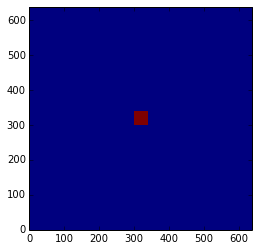

In [15]:
u = 0.00*np.ones((nx,ny),dtype=np.float32)
u[int(nx/2)-20:int(nx/2)+20,int(ny/2)-20:int(ny/2)+20]=1.0

u_g = gpuarray.to_gpu(u)
du_g = gpuarray.empty_like(u_g)
plt.imshow(u_g.get(),origin='top',vmin=0,vmax=1)

<matplotlib.colorbar.Colorbar instance at 0x7f06a0da3a28>

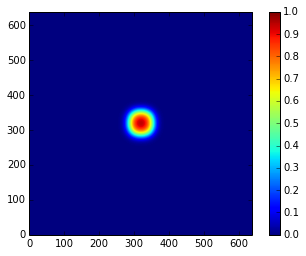

In [16]:
for i in range(251):
    RDS(u_g,du_g, block=(block_size,1,1), grid=(blocks,1))
    RDS(du_g,u_g, block=(block_size,1,1), grid=(blocks,1))

plt.imshow(u_g.get(),origin='top',vmin=0,vmax=1)
plt.colorbar()

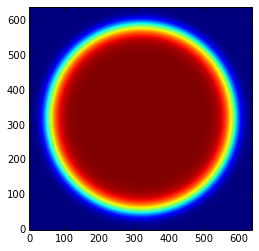

In [17]:
from IPython.core.display import clear_output

f, ax = plt.subplots()
ax.set_title("Fisher Kologomorow 2d")
for i in range(2111):
    RDS(u_g,du_g, block=(block_size,1,1), grid=(blocks,1))
    RDS(du_g,u_g, block=(block_size,1,1), grid=(blocks,1))
    if not i%150:
        ax.cla()
        
        ax.imshow(u_g.get(),origin='top',vmin=0,vmax=1)
        clear_output(wait=True)
        display(f)
plt.close()

Wizualiacja danych jako wykres powierzchni w 3d:

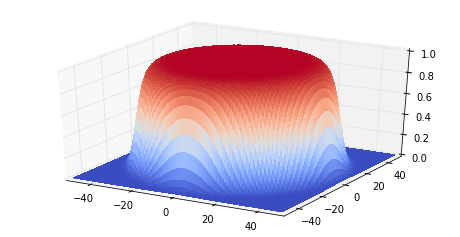

In [18]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure(figsize=(8,4))
ax = fig.gca(projection='3d')
X = np.linspace(-l/2, l/2,num=nx/8)
Y = np.linspace(-l/2, l/2,num=ny/8)
X, Y = np.meshgrid(X, Y)

Z = u_g.get()[::8,::8]
surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=cm.coolwarm,
        linewidth=0, antialiased=False)
ax.set_zlim(0, 1)
ax.set_xlim(-l/2,l/2)
ax.set_ylim(-l/2,l/2)

plt.show()




## 2d Bielusov Zabotynski RDS system


Fascynującym układem jest układ reakcji Bielusowa Zabotynskiego, w ktorym w pewnych przypadkach, połaczenie pobudliwej dynamiki z dyfuzją daje niezwykle efekty w postaci fal chemicznych.


In [19]:
# 2d Bielusov Zabotynski RDS system
import pycuda.gpuarray as gpuarray
import pycuda.driver as cuda
import pycuda.autoinit
from pycuda.compiler import SourceModule

try:
    ctx.pop()
    ctx.detach()
except:
    print "No CTX!"

cuda.init()
dev=cuda.Device(0)
dev.make_context()


block_size = 64
nx = 8*block_size
ny = nx
blocks = nx*ny/block_size


print "Nx = ",nx,"Ny = ",ny
l = 160

Dyf = 1.0
dt = 0.2/(Dyf*(nx-1)**2/l**2) # 0.2 z warunku CFL, krok nie moze byc mniejszy
a = 0.75 
b = 0.0006
eps = 0.05#72

pars = {'nx':nx,'ny':ny,'C':Dyf*(nx-1)**2/l**2,'a':a,'b':b,'1_eps':1.0/eps,'dt':dt}

print "dt=",dt
src = """
    __device__ float laplace2d(float *a)
    {{
      int idx = blockDim.x*blockIdx.x + threadIdx.x;

      float fe,fw,fs,fn;
      int nx={nx};
      int ny={ny};
    
      int x=idx%nx;
      int y=idx/nx;

      if(x>0) {{
           fw = a[idx-1]; 
        }}
      else{{
          fw = a[idx+nx-1];
      }}

      if(x<(nx-1)) {{
           fe = a[idx+1]; 
        }}
      else{{
          fe = a[idx-nx+1];
      }}

      if(y>0) {{
           fn = a[idx-nx]; 
        }}
      else{{
          fn = a[idx+nx*(ny-1)];
      }}

      if(y<(ny-1)) {{
           fs = a[idx+nx]; 
        }}
      else{{
          fs = a[idx-nx*(ny-1)];
      }}
        
     return(  fw+fe+fs+fn - 4.0f * a[idx] );

    }}

    __device__ float f(float x)
    {{ 

      return ( signbit(1.0f/3.0f - x )*(1-6.75*x*(1-x)*(1-x)) );

    }}
    __global__ void iterate_RDS(float *a,float *da,float *b,float *db,float epsilon)
    {{
      int idx = blockDim.x*blockIdx.x + threadIdx.x;
      float u,v;
       
      u = a[idx]; 
      v = b[idx]; 
          
      da[idx] = u + {dt}*(  (1.0f/epsilon)*u*(1-u)*(u-(v-{b})/{a}) + {C}*laplace2d(a) );
      db[idx] = v + {dt}*(  f(u)-v );
    }}
    """.format(**pars)

mod = SourceModule(src)
RDS = mod.get_function("iterate_RDS")
print "Kernel Ready"

Nx =  512 Ny =  512
dt= 0.0196077680462
Kernel Ready


Zadajemy warunki początkowe:

In [20]:
u = np.zeros((nx,ny),dtype=np.float32)
v = np.zeros((nx,ny),dtype=np.float32)

u[int(nx/4):int(3*nx/4),int(ny/2)-15:int(ny/2)+15]=1.0
v[int(nx/4):int(3*nx/4),int(ny/2)-17:int(ny/2)+3]=1.0
u_g = gpuarray.to_gpu(u)
du_g = gpuarray.empty_like(u_g)

v_g = gpuarray.to_gpu(v)
dv_g = gpuarray.empty_like(v_g)
#imshow(u_g.get(),origin='top',vmin=0,vmax=1)
print 'IC set:',u.shape

IC set: (512, 512)


In [21]:
def transition(a0,a1,n,i):
    return a0+(a1-a0)*0.5*(np.tanh(-5+10*i/float(n))+1.0)


In [22]:
newparams = { 'savefig.dpi': 150/2, 'figure.figsize': (15., 15.) }
plt.rcParams.update(newparams)


## Animacja na żywo

Z pomocą funkcji ipython-a możemy podczas symulacji wyświetlać stan pola inhibitora. Zbadajmy w ten sposób przejście do chaosu:

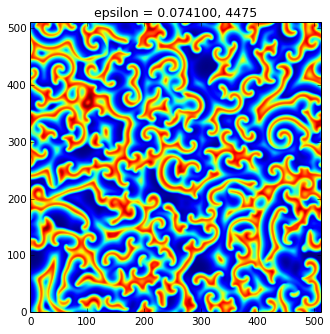

In [25]:
from IPython.core.display import clear_output
import time
f, ax = plt.subplots()
ax.set_title("Bielousow Zabotynski z dyfuzją 2d")

for i in range(5001):
    epsilon = np.float32( transition(0.05,0.0741,1000,i) ) 
    RDS(u_g,du_g,v_g,dv_g,epsilon, block=(block_size,1,1), grid=(blocks,1))
    RDS(du_g,u_g,dv_g,v_g,epsilon, block=(block_size,1,1), grid=(blocks,1))   
    if not i%25 and i<4500:
        #time.sleep(1) # CUDA works too fast ;-)
        ax.cla()
        #ax.plot(u)
        ax.set_title("epsilon = %03f, %d"%(epsilon,i))

        ax.imshow(v_g.get(),origin='top')   
        plt.savefig("1.png")
        clear_output(wait=True)
        display(f)
plt.close()

## Zadania

### Równanie falowe

Zaimplementuj równanie falowe w dwóch wymiarach.


